# Classification with Naive Bayes

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Assignment 1

Name: Taku Ueki

Student ID:u5934839

## Instructions

|             |Notes|
|:------------|:--|
|Maximum marks| 19|
|Weight|19% of final grade|
|Format| Complete this ipython notebook. Do not forget to fill in your name and student ID above|
|Submission mode| Use [wattle](https://wattle.anu.edu.au/)|
|Formulas| All formulas which you derive need to be explained unless you use very common mathematical facts. Picture yourself as explaining your arguments to somebody who is just learning about your assignment. With other words, do not assume that the person marking your assignment knows all the background and therefore you can just write down the formulas without any explanation. It is your task to convince the reader that you know what you are doing when you derive an argument. Typeset all formulas in $\LaTeX$.|
| Code quality | Python code should be well structured, use meaningful identifiers for variables and subroutines, and provide sufficient comments. Please refer to the examples given in the tutorials. |
| Code efficiency | An efficient implementation of an algorithm uses fast subroutines provided by the language or additional libraries. For the purpose of implementing Machine Learning algorithms in this course, that means using the appropriate data structures provided by Python and in numpy/scipy (e.g. Linear Algebra and random generators). |
| Late penalty | For every day (starts at midnight) after the deadline of an assignment, the mark will be reduced by 20%. No assignments shall be accepted if it is later than 5 days. | 
| Cooperation | All assignments must be done individually. Cheating and plagiarism will be dealt with in accordance with University procedures (please see the ANU policies on [Academic Honesty and Plagiarism](http://academichonesty.anu.edu.au)). Hence, for example, code for programming assignments must not be developed in groups, nor should code be shared. You are encouraged to broadly discuss ideas, approaches and techniques with a few other students, but not at a level of detail where specific solutions or implementation issues are described by anyone. If you choose to consult with other students, you will include the names of your discussion partners for each solution. If you have any questions on this, please ask the lecturer before you act. |
| Solution | To be presented in the tutorials. |

$\newcommand{\dotprod}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\onevec}{\mathbb{1}}$
$\newcommand{\B}[1]{\mathbf{#1}}$
$\newcommand{\Bphi}{\boldsymbol{\mathsf{\phi}}}$
$\newcommand{\BPhi}{\boldsymbol{\Phi}}$
$\newcommand{\Cond}{\,|\,}$
$\newcommand{\DNorm}[3]{\mathcal{N}(#1\Cond#2, #3)}$
$\newcommand{\DUniform}[3]{\mathcal{U}(#1 \Cond #2, #3)}$
$\newcommand{\Ex}[2][]{\mathbb{E}_{#1} \left[ #2 \right]}$
$\newcommand{\var}[1]{\operatorname{var}[#1]}$
$\newcommand{\cov}[1]{\operatorname{cov}[#1]}$
$\newcommand{\Norm}[1]{\lVert#1\rVert}$
$\DeclareMathOperator*{\argmax}{arg\,max}$

Setting up the environment (Please evaluate this cell to activate the $\LaTeX$ macros.)

In [1]:
import csv, scipy, scipy.stats, collections, itertools
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## The data set


The data set contains census information. Our task is to predict whether an indivual earns more than some amount.

Please download the following data:
* https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

Read and preprocess the data.

In [2]:
raw_data = np.genfromtxt("adult.data", dtype=str, delimiter=',', autostrip=True)

# targets
target = ">50K"
target_column = raw_data[:,-1]
Y = (target_column == target).reshape(-1,1)
assert any(Y) and any(~Y), set(target_column)

features = [
    'age', 'workclass', 'fnlwgt','education', 'education_num', 'marital_status', 
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
    'hours_per_week', 'native_country'
]

raw_features = raw_data[:,:-1] # drop the target
assert raw_features.shape[1] == len(features)


def preprocess_continuous(column):
    # convert continuous variables stored as strings to binary by comparing with the median
    float_column = column.astype(float)
    return (float_column > np.median(float_column)).astype(float).reshape(-1,1)


def preprocess_categorical(column):
    # convert categorical variables to indicator vectors
    values = sorted(set(column))
    if len(values) == 2:
        values = values[:1]
    return np.hstack([column.reshape(-1,1)==v for v in values]).astype(float)


preprocessor = collections.defaultdict(lambda: preprocess_categorical)
preprocessor.update(dict(
    age=preprocess_continuous, 
    fnlwgt=preprocess_continuous, 
    education_num=preprocess_continuous,
    capital_gain=preprocess_continuous, 
    capital_loss=preprocess_continuous, 
    hours_per_week=preprocess_continuous,
))

# apply appropriate preprocessor to each column of raw_features
X_list = [preprocessor[feature](raw_features[:,features.index(feature)]) for feature in features]
for feature, X in zip(features, X_list):
    assert X.shape[0] == raw_features.shape[0]
    print(X.shape[1], '\t', feature)
    
make_feature_names = lambda feature, dimension: ['%s_%.2i' % (feature, i) for i in range(dimension)]
binary_feature_names_list = [make_feature_names(feature, X.shape[1]) for feature, X in zip(features, X_list)]
binary_feature_names = list(itertools.chain(*binary_feature_names_list))

X = np.hstack(X_list)
assert set(X.flatten()) == {0.0, 1.0}
assert len(binary_feature_names) == X.shape[1]

1 	 age
9 	 workclass
1 	 fnlwgt
16 	 education
1 	 education_num
7 	 marital_status
15 	 occupation
6 	 relationship
5 	 race
1 	 sex
1 	 capital_gain
1 	 capital_loss
1 	 hours_per_week
42 	 native_country


Plot the data.

In [3]:
print(Y[:10])

[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]]



X.shape 	 (32561, 107)
Y.shape 	 (32561, 1)

mean(Y) 0.240809557446
(1200, 107)
(1200, 1)
1


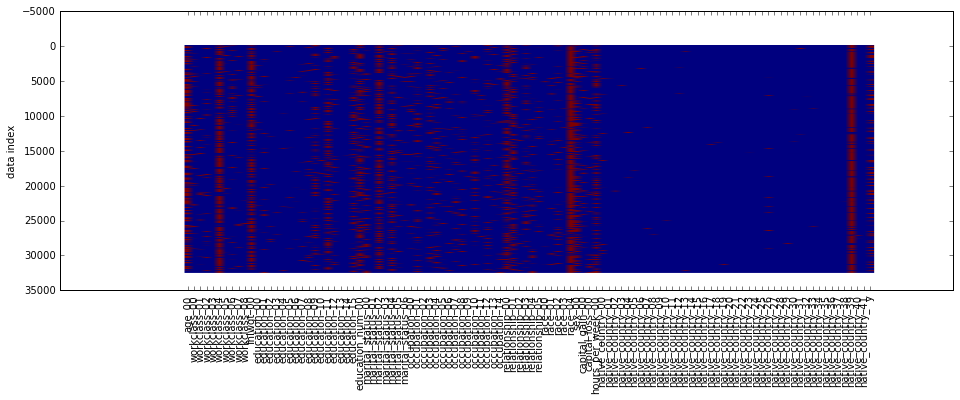

In [4]:
print('')
print('X.shape', '\t', X.shape)
print('Y.shape', '\t', Y.shape)
print()
print('mean(Y)', np.mean(Y))

figure = lambda : plt.figure(figsize=(16,5))
figure()
plt.imshow(np.hstack((X,Y)))
plt.axis('auto')
plt.ylabel('data index');
plt.gca().set_xticks(list(range(X.shape[1]+1)))
plt.gca().set_xticklabels(binary_feature_names+['y'], rotation='vertical')

ntrain = 1200
ishuffle = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(ishuffle)
itrain = ishuffle[slice(0,ntrain)]
itest = ishuffle[slice(ntrain,None)]
X_train, Y_train = X[itrain,:], Y[itrain,:]
X_test, Y_test = X[itest,:], Y[itest,:]
print(X_train.shape)
print(Y_train.shape)
print(True * 1)

## (3 points) 1A: Naive Bayes: Maximum Likelihood (m.l.)
Assume we have dataset $\mathcal{D}=\left\{(\mathbf{x}_i,y_i\right)\}_{i=1,2,\ldots,n}$ where $\mathbf{x}_i\in\{0,1\}^d$, $y_i\in\{0,1\}$, $n$ is the number of data points and $d$ the number of features.
1. State the independence assumption of the naive Bayes classifier.
- Appropriately assume Bernoulli random variables. Letting $p(x_j=1|y=k) = \rho_{j,k}$ for $k=0,1$ and $p(y=1)=\mu$, derive the maximum likelihood $\rho_{j,k}$ and $\mu$ (that is, the parameters which maximise the likelihood).
- Implement a function which computes these maximum likelihood parameters, and call it on ```X_train, Y_train```.
- Plot the $\rho_{j,k}$ (vertical) vs. $j$ (horizontal) using ```plt.plot``` with ```marker='.'```, labeling appropriately.
- Print the number of $\rho_{j,k}$ which are zero.
- Explain the problems which zero- (or one-) valued $\rho_{j,k}$ can lead to.

### <span style="color:blue">Answer</span>
1. $p(x_i, x_{i+1}, x_{i+2},..., x_{n}| y_k) = \displaystyle \prod_{i=1}^{n} p(x_i|y_k)$


2.
$p(x_j=1 | y=k) = \rho_{j,k}$ , $p(x_j=0 | y=k) = 1 - \rho_{j,k}$
<br/>
<br/>
$p(y=1) = \mu$ , $p(y=0) = 1 - \mu$
<br/>
<br/>
$p(\mathbf{Y} | \mathbf{X}) \propto p(\mathbf{X} | \mathbf{Y})p(\mathbf{Y}) = \displaystyle \prod_{i=1}^{n} p(\mathbf{x_i} | \mathbf{y_i})p(\mathbf{y_i})$

\begin{equation}
\begin{split}
L(\rho, \mu) = p(\mathbf{X} | \mathbf{Y})p(\mathbf{Y})
  &=
  \displaystyle \prod_{i=1}^{n} p(\mathbf{x_i} | \mathbf{y_i})p(\mathbf{y_i})
  \\&=
  \displaystyle \prod_{i=1}^{n} p(y_i = 1)^{y_i}p(y_i=0)^{1-y_i} \prod_{j=1}^{d} p(x_j=1 | y_i=k)^{x_j^{(i)}} p(x_j=0 | y_i=k)^{1-x_j^{(i)}}
  \\&=
  \displaystyle \prod_{i=1}^{n} \mu^{y_i}(1-\mu)^{1-{y_i}} \prod_{j=1}^{d} \rho_{j,k}^{x_j^{(i)}} (1-\rho_{j,k})^{1-x_j^{(i)}}
\end{split}
\end{equation}
\begin{equation}
\begin{split}
E(\rho, \mu) = -\ln L(\rho, \mu)
  &=
  \displaystyle -(\sum_{i=1}^{n} {y_i} \ln \mu + (1-{y_i})\ln(1-\mu) + \sum_{j=1}^{d} {x_j^{(i)}}\ln\rho_{j,k} + ({1-x_j^{(i)}})\ln(1-\rho_{j,k}))
\end{split}
\end{equation}
\begin{equation}
\begin{split}
\frac{\partial E(\rho, \mu)}{\partial \rho_{j,k}}
  &=
  \displaystyle \sum_{i=1}^{n} \sum_{j=1}^{d} \frac{{1-x_j^{(i)}}}{1-\rho_{j,k}} - \frac{{x_j^{(i)}}}{\rho_{j,k}}
\end{split}
\end{equation}
Set $\frac{\partial E(\rho, \mu)}{\partial \rho_{j,k}} = 0$
$$\displaystyle \sum_{i=1}^{n} \sum_{j=1}^{d} \rho_{j,k}(1-x_j^{(i)}) - x_j^{(i)}(1-\rho_{j,k}) = 0$$

$$\displaystyle \sum_{i=1}^{n} \sum_{j=1}^{d} \rho_{j,k} - x_j^{(i)} = 0$$

$$\displaystyle \sum_{i=1}^{n} \sum_{j=1}^{d} \rho_{j,k} = \sum_{i=1}^{n} \sum_{j=1}^{d} x_j^{(i)}$$

$$\displaystyle \sum_{i=1}^{n} \sum_{j=1}^{d} \sum_{k=0}^{0,1} \rho_{j,k} = \sum_{i=1}^{n} \sum_{j=1}^{d} \sum_{k=0}^{0,1} x_j^{(i)} \text{ (where } y_i = k)$$

$$\rho_{j,k} = \frac{count(x_j=1) \text{ where } y_i = k}{count(y_i = k)}$$

\begin{equation}
\begin{split}
\frac{\partial E(\rho, \mu)}{\partial \mu}
  &=
  \displaystyle \sum_{i=1}^{n} \frac{1-y_i}{1-\mu} - \frac{y_i}{\mu} = 0
\end{split}
\end{equation}

Set $\frac{\partial E(\rho, \mu)}{\partial \mu} = 0$

$$\displaystyle \sum_{i=1}^{n} \mu(1-y_i) - y_i(1-\mu) = 0$$

$$\displaystyle \sum_{i=1}^{n} \mu - y_i = 0$$

$$\mu = \displaystyle \frac{1}{n}\sum_{i=1}^{n} y_i= \frac{count(y=1)}{n}$$

0.265


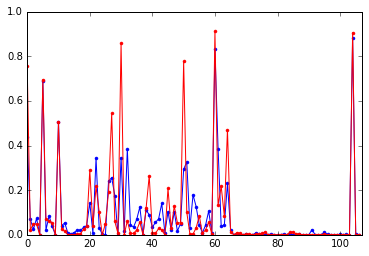

the number of ρj,k which are zero is 51


In [5]:
def cal_mu(y):
    #count the number of datapoints where y = 1
    return y.mean()
def cal_rho_ml(X, y):
    # make empty arrays to store rho values
    rho_true = np.zeros(X.shape[1])
    rho_false = np.zeros(X.shape[1])
    
    # count the number of datapoints where y = 1 and y = 0 seperately
    num_true = y.sum()
    num_false = y.shape[0] - num_true
    
    # get the indices of datapoints where y = 1 an y = 0 seperately
    y_true = np.where(Y_train==True)[0]
    y_false = np.where(Y_train==False)[0]
    
    #get features of datapoints in each class(y=1 and y=0) according to the indices I got from previous step
    X_true = X[y_true]
    X_false = X[y_false]
    
    #sum up each class's X matrix's column and divide it by the number of datapoints in each class
    rho_true = np.sum(X_true, axis=0)
    rho_true = rho_true/num_true
    rho_false = np.sum(X_false, axis=0)
    rho_false = rho_false/num_false
    return np.vstack((rho_false, rho_true))

print(cal_mu(Y_train))
rho_jk_ml = cal_rho_ml(X_train, Y_train)
rho_true_ml = rho_jk_ml[0]
rho_false_ml = rho_jk_ml[1]

x = np.arange(0,107)
plt.plot(x, rho_true_ml, marker=".", c="b")
plt.plot(x, rho_false_ml, marker=".", c="r")
plt.axis([0, 107, 0, 1])
plt.show()

a = np.where(rho_true_ml==0)[0]
b = np.where(rho_false_ml==0)[0]
print("the number of ρj,k which are zero is " + str(a.shape[0] + b.shape[0]))

6.Since in the likelihood funtion all values are multiplied , if there is a variable which is zero, result will be zero.

## (3 points) 1B: Naive Bayes: Maximum a Posteriori (m.a.p.)
Let $\rho_{j,k}\sim\text{Beta}(\beta)$, with p.d.f. $f_{\rho_{j,k}}(\rho)=\frac{\rho^{\beta-1}(1-\rho)^{\beta-1}}{Z(\beta)}$ where $Z$ is a normalisation factor. Assume a uniform prior for $\mu$.
1. Derive the maximum a posteriori $\rho_{j,k}$ and $\mu$ given the above prior.
- Implement a function which computes these maximum a posteriori parameters.
- Verify with ```assert np.allclose()``` that the m.a.p. solution with $\beta=1$ is identical to the m.l. solution. 
- Call your function on ```X_train, Y_train``` with $\beta=10,100,1000$. For each case scatter plot the m.a.p. parameters vs. the m.l. parameters, all on one axis, colored and labelled appropriately.
- Give one example of the role of $\beta$ as evidenced by the plot.

### <span style="color:blue">Answer</span>
$p(x_j=1 | y=k) = \rho_{j,k}$ , $p(x_j=0 | y=k) = 1 - \rho_{j,k}$
<br/>
<br/>
$p(y=1) = \mu$ , $p(y=0) = 1 - \mu$
<br/>
<br/>

\begin{equation}
\begin{split}
L(\rho, \mu) = p(Y|\rho,\mu) p(\rho,\mu)
  &=
  \displaystyle \prod_{i=1}^{n} p(\mathbf{x_i} | \mathbf{y_i})p(\mathbf{y_i}) p(\rho)p(\mu)
  \\&=
  \displaystyle \prod_{i=1}^{n} p(y_i = 1)^{y_i}p(y_i=0)^{1-y_i} \prod_{j=1}^{d} p(x_j=1 | y_i=k)^{x_j^{(i)}} p(x_j=0 | y_i=k)^{1-x_j^{(i)}} \frac{\rho^{\beta-1}(1-\rho)^{\beta-1}}{Z(\beta)} \frac{1}{\mu}
  \\&=
  \displaystyle \prod_{i=1}^{n} \mu^{y_i}(1-\mu)^{1-{y_i}} \prod_{j=1}^{d} \rho_{j,k}^{x_j^{(i)}} (1-\rho_{j,k})^{1-x_j^{(i)}} \frac{\rho^{\beta-1}(1-\rho)^{\beta-1}}{Z(\beta)} \frac{1}{\mu}
\end{split}
\end{equation}
\begin{equation}
\begin{split}
E(\rho, \mu) = -\ln L(\rho, \mu)
  &=
  \displaystyle -(\sum_{i=1}^{n} {y_i} \ln \mu + (1-{y_i})\ln(1-\mu) + \sum_{j=1}^{d} {x_j^{(i)}}\ln\rho_{j,k} + ({1-x_j^{(i)}})\ln(1-\rho_{j,k}) + \ln \frac{\rho^{\beta-1}(1-\rho)^{\beta-1}}{Z(\beta)} - \ln\mu)
  \\&=
  \displaystyle -(\sum_{i=1}^{n} {y_i} \ln \mu + (1-{y_i})\ln(1-\mu) + \sum_{j=1}^{d} {x_j^{(i)}}\ln\rho_{j,k} + ({1-x_j^{(i)}})\ln(1-\rho_{j,k}) + (\beta-1)\ln\rho + (\beta-1)\ln(1-\rho) - \ln(Z(\beta)) - \ln\mu)
\end{split}
\end{equation}
\begin{equation}
\begin{split}
\frac{\partial E(\rho, \mu)}{\partial \rho_{j,k}}
  &=
  \displaystyle \sum_{i=1}^{n} (\sum_{j=1}^{d} \frac{{1-x_j^{(i)}}}{1-\rho_{j,k}} - \frac{{x_j^{(i)}}}{\rho_{j,k}} ) - \frac{\beta-1}{\rho} + \frac{\beta-1}{1-\rho}
\end{split}
\end{equation}
Set $\frac{\partial E(\rho, \mu)}{\partial \rho_{j,k}} = 0$

$$\displaystyle \sum_{i=1}^{n}( \sum_{j=1}^{d} \rho_{j,k}(1-x_j^{(i)}) - x_j^{(i)}(1-\rho_{j,k})) - (\beta-1)(1-\rho) - (\beta-1)\rho = 0$$
$$\displaystyle \sum_{i=1}^{n}( \sum_{j=1}^{d} (x_j^{(i)} - \rho_{j,k})) + 2\rho(\beta -1) - \beta + 1 = 0$$



$$\rho_{j,k} = \frac{count(x_j=1,y_i = k) + \beta - 1}{count(y_i = k) + 2(\beta -1)}$$

\begin{equation}
\begin{split}
\frac{\partial E(\rho, \mu)}{\partial \mu}
  &=
  \displaystyle \sum_{i=1}^{n} \frac{1-y_i}{1-\mu} - \frac{y_i}{\mu} + \frac{1}{\mu} = 0
  \\&=
  \displaystyle \sum_{i=1}^{n}( \mu(1-y_i) - y_i(1-\mu)) + (1-\mu)
  \\&=
  \displaystyle \sum_{i=1}^{n}( \mu - y_i) + 1- \mu = 0
\end{split}
\end{equation}

Set $\frac{\partial E(\rho, \mu)}{\partial \mu} = 0$

$$\displaystyle \sum_{i=1}^{n}( \mu(1-y_i) - y_i(1-\mu)) + (1-\mu) = 0$$

$$\displaystyle \sum_{i=1}^{n}( \mu - y_i) + 1- \mu = 0$$

$$\mu = \frac{count(y=1) - 1}{n - 1}$$

In [6]:
def cal_mu_map(y):
    #count the number of datapoints where y = 1
    return (y.sum() - 1) / (y.shape[0] - 1)

def cal_rho_map(X, y, beta):
    # do same thing as the previous question
    rho_true = np.zeros(X.shape[1])
    rho_false = np.zeros(X.shape[1])
    num_true = y.sum()
    num_false = y.shape[0] - num_true
    y_true = np.where(Y_train==True)[0]
    y_false = np.where(Y_train==False)[0]
    X_true = X[y_true]
    X_false = X[y_false]
    
    # count the number of datapoints where x_j = 1 and calculate rho according to the formula I got from q1
    rho_true = np.sum(X_true, axis=0)
    rho_true = (rho_true + beta - 1) / (num_true + 2*(beta-1))
    rho_false = np.sum(X_false, axis=0)
    rho_false = (rho_false + beta - 1) / (num_false + 2*(beta-1))
    return np.vstack((rho_false, rho_true))

rho_jk_map = cal_rho_map(X_train, Y_train, 1)
rho_true = rho_jk_map[0]
rho_false = rho_jk_map[1]

assert np.allclose(cal_rho_map(X_train, Y_train, 1), rho_jk_ml)

x = np.arange(0,107)
plt.figure()
plt.plot(x, rho_true, marker=".", c="blue", label="rho_true_ml")
plt.plot(x, rho_false, marker=".", c="red", label="rho_false_ml")
rho_jk = cal_rho_map(X_train, Y_train, 10)
plt.plot(x, rho_jk[0], marker=".", c="green", label="rho_true_map")
plt.plot(x, rho_jk[1], marker=".", c="yellow", label="rho_false_map")
plt.axis([0, 107, 0, 1])
plt.legend()

plt.figure()
plt.plot(x, rho_true, marker=".", c="blue", label="rho_true_ml")
plt.plot(x, rho_false, marker=".", c="red", label="rho_false_ml")
rho_jk = cal_rho_map(X_train, Y_train, 100)
plt.plot(x, rho_jk[0], marker=".", c="green", label="rho_true_map")
plt.plot(x, rho_jk[1], marker=".", c="yellow", label="rho_false_map")
plt.axis([0, 107, 0, 1])
plt.legend()

plt.figure()
plt.plot(x, rho_true, marker=".", c="blue", label="rho_true_ml")
plt.plot(x, rho_false, marker=".", c="red", label="rho_false_ml")
rho_jk = cal_rho_map(X_train, Y_train, 1000)
plt.plot(x, rho_jk[0], marker=".", c="green", label="rho_true_map")
plt.plot(x, rho_jk[1], marker=".", y.c="yellow", label="rho_false_map")
plt.axis([0, 107, 0, 1])
plt.legend()

SyntaxError: keyword can't be an expression (<ipython-input-6-7b8d0a179f3b>, line 53)

5. $\beta$ makes the rho values which are 0 without $\beta$ to some values between 0 and 1. So by adding $\beta$ we can avoid the problem of factorizing feature which value is 0. Even if a datapoint includes features which are zero, the result will not be 0 when we factorize the feature values.

## (2 points) 1C: Naive Bayes: Prediction
1. Derive the log predictive distribution $\log p(y=1|\mathbf{x},\{\rho_{j,k}\},\mu)$. Where appropriate, implement this by adding log probabilities instead of multiplying probabilities. Use ```np.logaddexp``` to add probabilities stored in log space.
- Call the above funcion on ```X_test``` using m.a.p. parameters computed with $\beta=2$.
- Plot a histogram of the probabilities (use ```np.exp``` on the log probabilities) using ```plt.hist``` with ```normed=True,histtype='step',label='your_label'```. Do this for the predictive test probabilities corresponding to ```Y_test==1``` and ```Y_test==0```, puting the histograms on the same plot, labeling appropriately.

### <span style="color:blue">Answer</span>
\begin{equation}
\begin{split}
p(y=1|\mathbf{x},\{\rho_{j,k}\},\mu)
  &=
  \frac{p(y=1, \mathbf{x},\{\rho_{j,k}\},\mu)}{p(\mathbf{x},\{\rho_{j,k}\},\mu)}
  \\&=
  \frac{p(\mathbf{x},\{\rho_{j,k}\},\mu|y=1)p(y=1)}{p(\mathbf{x},\{\rho_{j,k}\},\mu|y=0)p(y=0) + p(\mathbf{x},\{\rho_{j,k}\},\mu|y=1)p(y=1)}
  \\&=
  \frac{p(\mathbf{x}|y=1)p(\{\rho_{j,k}\}|y=1)p(\mu|y=1)p(y=1)}{p(\mathbf{x}|y=0)p(\{\rho_{j,k}\}|y=0)p(\mu|y=0)p(y=0) + p(\mathbf{x}|y=1)p(\{\rho_{j,k}\}|y=1)p(\mu|y=1)p(y=1)}
  \\&=
  \frac{p(\mathbf{x}|y=1)p(y=1)}{p(\mathbf{x}|y=0)p(y=0) + p(\mathbf{x}|y=1)p(y=1)}
  \\&=
  \frac{\displaystyle \mu  \prod_{j=1}^{d} p(x_j | y=1)}{\displaystyle (1-\mu)  \prod_{j=1}^{d} p(x_j | y=0) + \mu  \prod_{j=1}^{d} p(x_j | y=1)}
  \\&=
  \frac{\displaystyle \mu  \prod_{j=1}^{d} \rho_{j,1}^{x_j}(1 - \rho_{j,1})^{1-x_j}}{\displaystyle (1-\mu)  \prod_{j=1}^{d} \rho_{j,0}^{x_j}(1 - \rho_{j,0})^{1-x_j} + \mu  \prod_{j=1}^{d} \rho_{j,1}^{x_j}(1 - \rho_{j,1})^{1-x_j}}
\end{split}
\end{equation}

\begin{equation}
\begin{split}
\log p(y=1|\mathbf{x},\{\rho_{j,k}\},\mu) 
   &= \displaystyle \log \mu + \sum_{j=1}^{d}( x_j \log \rho_{j,1} + (1-x_j) \log (1-\rho_{j,1})) 
  \\&-
  \log\{\log(1-\mu) + \sum_{j=1}^{d}( x_j \log \rho_{j,0} + (1-x_j) \log (1-\rho_{j,0})) + \log\mu + \sum_{j=1}^{d}( x_j \log \rho_{j,1} + (1-x_j) \log (1-\rho_{j,1}))\}
\end{split}
\end{equation}

In [ ]:
def log_predictive_distribution(x, rho, mu):
    # get the indices of features where x_j=1 and x_j=0 seperately
    feature_true = np.where(x==1)[0]
    feature_false = np.where(x==0)[0]
    
    #get the rho value for each index
    rho_true = rho[1]
    rho_false = rho[0]
    
    #calculate the formula which I derived from q1
    x1 = np.log(mu) + (np.log(rho_true[feature_true]).sum() + np.log(1-rho_true[feature_false]).sum())
    x2 = np.log((1-mu)) + (np.log(rho_false[feature_true]).sum() + np.log(1-rho_false[feature_false]).sum())

#     return np.log(mu) + (np.log(rho_true[feature_true]).sum() + np.log(1-rho_true[feature_false]).sum()) - np.logaddexp(x1, x2)
    return x1 - np.logaddexp(x1, x2)

rho = cal_rho_map(X_train, Y_train, 2)

y_true = np.where(Y_test==True)[0]
y_false = np.where(Y_test==False)[0]

X_true = X_test[y_true]
X_false = X_test[y_false]

probabilities_y_is_1 = []
probabilities_y_is_0 = []
for i in range(X_true.shape[0]):
    x = X_true[i]
    p = np.exp(log_predictive_distribution(x, rho, cal_mu_map(Y_train)))
    probabilities_y_is_1.append(p)

for i in range(X_false.shape[0]):
    x = X_false[i]
    p = np.exp(log_predictive_distribution(x, rho, cal_mu_map(Y_train)))
    probabilities_y_is_0.append(p)

probabilities_y_is_1 = np.asarray(probabilities_y_is_1)
probabilities_y_is_0 = np.asarray(probabilities_y_is_0)

plt.figure()
plt.hist(probabilities_y_is_1, color="blue", normed=True, histtype='step', label='Y_test==1')
plt.hist(probabilities_y_is_0, color="red", normed=True, histtype='step', label='Y_test==0')
plt.legend()

print(np.exp(log_predictive_distribution(X_train[0], rho, cal_mu_map(Y_train))))

## (2 points) 1D: Naive Bayes: Evaluation
1. Write a function ```evaluate``` which takes data ```X,Y``` and model parameters $\rho_{j,k}$ and $\mu$, and returns a dict with keys ```mean_logp_true``` (for the mean predictive log probability of the ground truth labels ```Y``` given the data matrix ```X``` and ```percent_correct``` (for the percent correctly classified, assuming we classify each datum into the class with maximum predictive probability).
- Write a function ```cross_validate(beta, nfolds, X, Y)``` which performs cross validation with ```nfolds``` folds, for hyper parameter $\beta$. For each split, call your ```evaluate``` function, and return a ```dict``` with averaged results for each evaluation metric. You can make use of our ```xval_inds``` function.
- For $\beta$ in ```np.logspace(np.log10(2),2,32)``` compute the evaluation metrics on the test set, ```X_test, Y_test```, as well as the cross-validated estimates. Make one plot for each metric, showing both results on each (for a total of four curves). Label appropriately.

In [ ]:
def xval_inds(ndata, nfolds):
    # return a list of (trainind, testind) pairs for ndata data points and nfolds xval folds
    assert ndata % nfolds == 0
    nchunk = int(ndata / nfolds)
    itest = [list(range(i*nchunk,(i+1)*nchunk)) for i in range(int(nfolds))]
    itrain = [sorted(set(range(ndata)).difference(set(i))) for i in itest]
    return list(zip(itrain, itest))


### <span style="color:blue">Answer</span>

In [ ]:
def evaluation(X, y , rho, mu):
    #prepare empty array to store probabilities for each datapoint
    probabilities_true = np.empty(0)
    probabilities_false = np.empty(0)
    probabilities = np.empty(0)
    
    #divide the data into True and False one
    y_true = np.where(y==True)[0]
    y_false = np.where(y==False)[0]
    X_true = X[y_true]
    X_false = X[y_false]
    result = dict()
    num = 0
    #for each class get the probabilities and store that and check if the probability is greater than 0.5 and if it is increment the percent_correct and divide it by the number of datapints in the class
    for i in range(X_true.shape[0]):
        x = X_true[i]
        p = np.exp(log_predictive_distribution(x, rho, mu))
        probabilities_true = np.append(probabilities_true,p)
        probabilities = np.append(probabilities,p)
    
    #get the number of datapoints that the probability is greater than 0.5
    percent_correct = np.where(probabilities_true>0.5)[0].shape[0]

    for i in range(X_false.shape[0]):
        x = X_false[i]
        p = np.exp(log_predictive_distribution(x, rho, mu))
        probabilities_false = np.append(probabilities_false,1-p)
        probabilities = np.append(probabilities,1-p)
    #calculate the mean value of all probabilities
    result["mean_logp_true"] = probabilities.mean()
    #get the number of datapoints that the probability is greater than 0.5
    percent_correct += np.where(probabilities_false>0.5)[0].shape[0]
    # calculate the percent_coorect by dividing the number of datapoints which classified correctly by the number of datapoints
    result["percent_correct"] = percent_correct / y.shape[0]
    return result

# pred_true = evaluation(X_test, Y_test, cal_rho_map(X_train, Y_train, 2), cal_mu_map(Y_train))
pred_true = evaluation(X_train, Y_train, cal_rho_map(X_test, Y_test, 2), cal_mu_map(Y_test))
print(pred_true)

In [ ]:
def cross_validate(beta, nfolds, X, Y):
    inds_list = xval_inds(X.shape[0], nfolds)
    mean_logp_true_total = np.empty(0)
    percent_correct_total = np.empty(0)
    output = dict()
    
    for i in range(nfolds):
        x_train = X[inds_list[i][0]]
        x_test = X[inds_list[i][1]]
        y_train = Y[inds_list[i][0]]
        y_test = Y[inds_list[i][1]]
        rho = cal_rho_map(x_train, y_train, beta)
        mu = cal_mu_map(y_train)
        result = evaluation(x_test, y_test, rho, mu)
#         print(result)

        mean_logp_true = result["mean_logp_true"]
        mean_logp_true_total = np.append(mean_logp_true_total, mean_logp_true)

        percent_correct = result["percent_correct"]
        percent_correct_total = np.append(percent_correct_total, percent_correct)

    output["mean_logp_true"] = mean_logp_true_total.mean()
    output["percent_correct"] = percent_correct_total.mean()

    return output

# print(cross_validate(2, 11, X_test, Y_test))
print(cross_validate(2, 11, X_train, Y_train))

In [ ]:
mean_logp_true_cv = np.empty(0)
mean_logp_true_test_eval = np.empty(0)
percent_correct_cv = np.empty(0)
percent_correct_test_eval = np.empty(0)

for beta in np.logspace(np.log10(2),2,32):
    result = cross_validate(beta, 11, X_test, Y_test)
    mean_logp_true_cv = np.append(mean_logp_true_cv, result["mean_logp_true"])

    percent_correct_cv = np.append(percent_correct_cv, result["percent_correct"])

    result = evaluation(X_test, Y_test, cal_rho_map(X_train, Y_train, beta), cal_mu_map(Y_train))
    mean_logp_true_test_eval = np.append(mean_logp_true_test_eval, result["mean_logp_true"])
    percent_correct_test_eval = np.append(percent_correct_test_eval, result["percent_correct"])

plt.figure()
plt.plot(np.logspace(np.log10(2),2,32), mean_logp_true_cv, color="red", label="mean_logp_true_cv")
plt.plot(np.logspace(np.log10(2),2,32), mean_logp_true_test_eval, color="blue", label="mean_logp_test_eval")
plt.legend()
plt.figure()
plt.plot(np.logspace(np.log10(2),2,32), percent_correct_cv, color="red", label="percent_correct_cv")
plt.plot(np.logspace(np.log10(2),2,32), percent_correct_test_eval, color="blue", label="percent_correct_test_eval")
plt.legend()

## (2 points) 1E: Naive Bayes: Discussion
1. Explain the shortcomings of our preprocessing of (a) continous variables, and (b) categorical variables. Make note of the assumptions of our model.
- Suggest improvements to our data processing pipeline, both in terms of the representation and the model.
- Consider the distribution $p(a,b,c)$ where all three variables are binary. How many parameters are needed to specify this distribution (a) in general and (b) if it factorises as $p(a|c)p(b|c)p(c)$?

### <span style="color:blue">Answer</span>
1. (a)In our preprocessing of continuous varaiables, we are comparing each variable to the median value of the feature of all datapoints. Therefore, the problems are that this preprocessing ignores the distribution of the feature and not dividing the data into 2 groups carefully enough.
<br/><br/>
(b) We are making as many binary features as the number of the types of variable of the feature. If the feature has two category, this preprocessing makes two binary features, which means we can infer the second feature from the first one. For example a person is male, we can infer that this person is not female. Hence these features are not independent each other. This contradicts with the independent assumption of the Naive Bayse classifier.
<br/><br/>
2. About preprocessing of continuous variables, we should try to find peaks in the distribution of the feature in the data. If there are peaks, we shoud compare each variable to the values of trougs of the distribution and convert this feature to a multi class feature.
<br/><br/>
About preprocessing of categorical variables, count the number of classes that each feature can take and if that is 2, do not make 2 new features for it but keep this feature as it is. If there are more than 2 classes, make a multi class feature for this feature instead of making new binary features.
<br/><br/>
3. (a) In this case we have 3 binary variables. The number of combinations of parameters is $2^3 = 8$. However, you can represent one of the parameters by subtracting the total of the other parameters so you need $8 - 1 = 7$ parameters in genaral<br/><br/>
(b) We can represent $p(a|c)$ with two parameters like $p(a|c)$, $1 - p(a|c)$, $p(a|c')$ and $1 - p(a|c)$.so we need 4 parameters for first two conditional probabilities in total. Also we need one more parameter for p(c). Therefore, we need 5 parameters in total.

## (3 points) 2A: Representation Proof
Consider a parametric model governed by the parameter vector $\mathbf{w}$ together with a dataset of input values $\mathbf{x}_1,\ldots,\mathbf{x}_N$ and a nonlinear feature mapping $\phi(\mathbf{x})$. Suppose that the dependence of the error function on $\mathbf{w}$ takes the form $J(\mathbf{w}) = f(\mathbf{w}^\top \phi(\mathbf{x}_1), \ldots, \mathbf{w}^\top \phi(\mathbf{x}_N)) + g(\mathbf{w}^\top \mathbf{w})$
where $g(\cdot)$ is a monotonically increasing function. By writing $\mathbf{w}$ in the form
$$
\mathbf{w} = \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp
$$
show that the value of $\mathbf{w}$ that minimizes $J(\mathbf{w})$ takes the form of a linear combination of the basis functions $\phi(\mathbf{x}_n)$ for $n = 1, \ldots, N$.

### <span style="color:blue">Answer</span>
It is given that $\mathbf{w}$ can be written $$\mathbf{w} = \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp$$
To make it simple, rewrite $\sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n)$ to $\mathbf{w_*}$
$$\mathbf{w} = \mathbf{w_*} + \mathbf{w}_\perp$$
<br/>
$$\mathbf{w_*}  \mathbf{w}_\perp = 0$$
<br/>
As $w_\perp$ is orthogonal to the weighted sum of the feature mappings, for an arbitrary n 
$$\mathbf{w}_\perp^\top \phi(\mathbf{x}_n) = 0$$
<br/>
Therefore, $J(\mathbf{w})$ can be written
<br/>
\begin{equation}
\begin{split}
J(\mathbf{w})
  &=
  f((\mathbf{w_*} + \mathbf{w}_\perp)^\top \phi(\mathbf{x}_1), ... , (\mathbf{w_*} + \mathbf{w}_\perp)^\top \phi(\mathbf{x}_N)) + g((\mathbf{w_*}+\mathbf{w}_\perp)^\top(\mathbf{w_*}+\mathbf{w}_\perp))
  \\&=
  f(\mathbf{w_*}^\top \phi(\mathbf{x}_1) + \mathbf{w}_\perp^\top\phi(\mathbf{x}_1) , ... , \mathbf{w_*}^\top \phi(\mathbf{x}_N) + \mathbf{w}_\perp^\top\phi(\mathbf{x}_N) + g(\mathbf{w_*}^\top\mathbf{w_*}+\mathbf{w_*}\mathbf{w}_\perp^\top+\mathbf{w}_\perp\mathbf{w_*}^\top+\mathbf{w}_\perp^\top\mathbf{w}_\perp)
  \\&=
  f(\mathbf{w_*}^\top \phi(\mathbf{x}_1) , ... , \mathbf{w_*}^\top \phi(\mathbf{x}_N)) + g(\mathbf{w_*}^\top\mathbf{w_*}+\mathbf{w}_\perp^\top\mathbf{w}_\perp)
\end{split}
\end{equation}
<br/>
Since $g(⋅)$ is a monotonically increasing function, $g(⋅)$ is minimised when $\mathbf{w}_\perp = 0$.
<br/>
Therefore, $J(\mathbf{w})$ is minimized when $$\mathbf{w} = \mathbf{w_*} =  \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n)$$
So $\mathbf{w}$ takes the form of a linear combination of the basis funcitons $ \phi(\mathbf{x}_n)$ for $n = 1,...,N$ when minimizes $J(\mathbf{w})$

## (2 points) Maximum likelihood (ML) and Maximum A Posteriori (MAP)
We assume data samples $X_n = \{ x_1,\dots,x_n \}$ are generated i.i.d. from a uniform distribution
$ \DUniform{x}{0}{\theta} $ between $ 0 $ and an unknown positive parameter $\theta$:
$$
   p(x \Cond \theta) = \DUniform{x}{0}{\theta} = 
\begin{cases}
 1/\theta & 0 \leq x \leq \theta \\
 0        & \textrm{otherwise} \\
\end{cases}
$$

Assume the data samples $ X_4 = \{ 5, 7, 3, 9 \}$ have been observed.

1. Calculate $\theta_{ML} = \argmax_{\theta} p(X_4 \Cond \theta)$, 
the maximum likelihood estimate of $\theta$ for the observed data.

- Calculate $p(\theta \Cond X_4)$, the posterior distribution of $\theta$ given that the 
data $ X_4 $ have been observed and 
the initial distribution for $\theta$ is given as $p(\theta) = p(\theta \Cond X_0) = \DUniform{x}{0}{10}$.

- Calculate $\theta_{MAP} = \argmax_{\theta} p(\theta \Cond X_4)$, the maximum a posteriori
estimate of $\theta$ given the data $ X_4 $ and the initial distribution $p(\theta)$ as in the previous question.

- Calculate $\theta_{ML}$, $p(\theta \Cond X_4)$, and $\theta_{MAP}$ for the case that the observed data are $ X_4 = \{ 9, 5, 7, 3 \}$ instead of the $ X_4 = \{ 5, 7, 3, 9 \}$ given above.

### <span style="color:blue">Answer</span>
1. $p(X_4 | \theta) = \displaystyle \prod_{i=1}^{n} p(x_n | \theta) = (\frac{1}{\theta})^4$<br/>
$p(X_4|\theta)$ decreases as $\theta$ increases. Since $X_4 = \{5,7,3,9\}$ is observed $9 \leq \theta$.  Therefore, $\theta_{ML} = 9$
<br/>
<br/>
2. $p(\theta | X_4) = \frac{p(X_4 | \theta) p(\theta)}{\int_{-\infty}^{\infty} p(X_4|\theta)p(\theta)d\theta}$
<br/>
<br/>
Since $p(\theta) = p(\theta \Cond X_0) = \DUniform{x}{0}{10}$ , $p(\theta) = \frac{1}{10}$
<br/>
<br/>
$p(X_4 | \theta) p(\theta) = (\frac{1}{\theta})^4 \frac{1}{10}$
<br/>
<br/>
As $X_4 = \{5,7,3,9\}$ is observed and initial distribution for $\theta$ is given as $\DUniform{x}{0}{10}$ , the range of $\theta$ is $9 \leq \theta \leq 10$.
<br/>
<br/>
Therefore $$\int_{-\infty}^{\infty} p(X_4|\theta)p(\theta)d\theta = \int_{9}^{10} p(X_4|\theta)p(\theta)d\theta = \frac{1}{10}\int_{9}^{10} (\frac{1}{\theta})^4 d\theta = \frac{1}{10}(-\frac{1}{3 \times 10^3} + \frac{1}{3 \times 9^3})$$
<br/>
<br/>
Plug them into $p(\theta | X_4)$ and we get $$p(\theta | X_4) = \frac{(\frac{1}{\theta})^4 \frac{1}{10}}{\frac{1}{10}(-\frac{1}{3 \times 10^3} + \frac{1}{3 \times 9^3})} = \frac{3 \times 10^3 \times 9^3}{(10^3 - 9^3)\theta^4} = \frac{3 \times 10^3 \times 9^3}{271\theta^4}$$
<br/>
<br/>
3. As I mentioned in the previous question, the range of $\theta$ is $9 \leq \theta \leq 10$ and also 
$$p(\theta | X_4) = \frac{3 \times 10^3 \times 9^3}{271\theta^4}$$
$p(\theta | X_4)$ also decreases as $\theta$ increases. So we can know that $p(\theta | X_4)$ is maximised when $\theta = 9$.
<br/>
<br/>
Therefore $\theta_{MAP} = 9$
<br/>
<br/>
4. The only difference is the order of the observed data and the order does not matter with $\theta_{MAP}$ and $\theta_{ML}$.
<br/>
<br/>
Therefore $\theta_{ML} = \theta_{MAP} = 9$.

## (2 points) Laplace Approximation
The function
$$
  f(z) = z^k e^{-z^2/2} \qquad \qquad z \in [0, \infty), \qquad k > 0
$$
can be considered as an (unnormalised) probability density.

1. Verify that it is possible to approximate $ f(z) $ with the Laplace Approximation.

- Using the Laplace Approximation, find the mean and the variance of the Normal Distribution which best approximates the normalised version of $ f(z) $.

- The analytical form of the normalisation of $ f(x) $ is not so easy to find. Therefore, use Python to implement a numerical approximation using $ N = 100 $ identically sized intervals between $ 0 $ and $ a = 10 $ to calculate the normalisation 
$$
  \int_0^{\infty} f(z) \mathrm{d}z 
  \approx \int_0^{a} z^k e^{-z^2/2} \mathrm{d}z 
  \approx \sum_{i=1}^{100} \dots
$$
and report the results for the normalisation with a 
precision of $5$ digits after the comma for the three cases $ k = \{0.5, 3, 5 \}$.
            
- For each of the three cases $ k = \{0.5, 3, 5 \}$, plot the normalised function $ f(z) $
and the corresponding Normal Distribution with parameters  resulting from the Laplace Approximation.

- Why is it reasonable to replace the upper limit of $ \infty$ with $ a = 10 $ ?

### <span style="color:blue">Answer</span>
The condition to approximate f(z) with the Laplace Approximation is that $A = -\frac{d^2}{dz^2}\ln f(z) |_{z=z_0} > 0$ $z_0$ is a point where $f'(z_0) = 0$.
<br/>
<br/>
\begin{equation}
\begin{split}
f'(z)
  &=
  kz^{k-1}e^{-z^2/2} + z^k (-z) e^{-z^2/2}
  \\&=
  kz^{k-1}e^{-z^2/2} - z^{k+1} e^{-z^2/2}
  \\&=
  (k-z^2)z^{k-1}e^{-z^2/2}
\end{split}
\end{equation}
Set $f'(z_0) = 0$ and we get $$k = z_0^2$$ $$z_0 = \pm \sqrt{k}$$
<br/>
<br/>
Now we calculate $\frac{d^2}{dz^2}\ln f(z_0)$
$$\ln f(z)  =   \ln z^k e^{-z^2/2} =  k\ln z - \frac{z^2}{2}$$
$$\frac{d}{dz}\ln f(z) = \frac{k}{z} - z$$
$$\frac{d^2}{dz^2}\ln f(z_0) = -\frac{k}{z_0^2} - 1 = -\frac{k}{k} - 1 = -2$$
Therefore $$A = -\frac{d^2}{dz^2}\ln f(z) |_{z=z_0} = 2 > 0$$
Hence it is verified that it is possible to approximate f(z) with the Laplace Approximation.

The mean and the variance of the Normal Distribution which best approximates the normalised version of f(z) are
$$\sigma^2 = \frac{1}{A} = \frac{1}{2}$$
$$\mu = z_0 = \sqrt{k}$$

5.$f(10) = 10^k \times e^{-50} \simeq 10^k \times 1.93 \times 10^{-22}$
<br/>
<br/>
In this question we thought about only three cases $k = \{0.5, 3, 5\}$ and in any of these cases the  value of $f(10)$ is very small and we can assume that it is similar equal to zero, and this value will decrease as $z$ increases. Hence, we do not need to consider those values and it is reasonable to replace the upper limit of $\infty$ with a=10 

In [ ]:
def f(z, k):
    return z**k * np.exp(-z**2/2)
def N_(z, k):
    return 1/np.sqrt(np.pi) * np.exp(-(z - np.sqrt(k))**2)

a = 10
N = 100
z = np.arange(0,a,a/N)
ks = [0.5, 3, 5]
for k in ks:
    normalise = f(z, k).sum()*a/N
    print(normalise)
    plt.figure()
    plt.plot(z, f(z, k)/normalise, color="blue", label="original curve")
    plt.plot(z, N_(z, k), color="red", label="Laplace Approximation")
    plt.legend()